In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

from models.monotonic import *

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

## 1. Preprocessing

In [2]:
data = pd.read_excel('../data/bank_null.xlsx')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
1,33.0,services,married,secondary,no,4789.0,yes,yes,cellular,11.0,may,220.0,1.0,339.0,4.0,failure,no
2,35.0,management,single,tertiary,no,1350.0,yes,no,cellular,16.0,apr,185.0,1.0,330.0,1.0,failure,no
3,30.0,management,married,tertiary,no,1476.0,yes,yes,unknown,3.0,jun,199.0,4.0,-1.0,0.0,unknown,no
4,59.0,blue-collar,married,secondary,no,0.0,yes,no,unknown,5.0,may,226.0,1.0,-1.0,0.0,unknown,no


### In-Sample and Out-of-Sample split

In [3]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

In [4]:
X = data.drop(columns='y').values
y = (data['y']=='yes').astype(int)

for train_index, test_index in sss.split(X, y):
    X_in, X_out = X[train_index], X[test_index]
    y_in, y_out = y[train_index], y[test_index]
    
    data_in = data.iloc[train_index]
    data_out = data.iloc[test_index]
    print('Share of "good" in Out-of-Sample = {}'.format(np.sum(y_out)/len(y_out)))
    print('Share of "good" in In-Sample     = {}'.format(np.sum(y_in)/len(y_in)))

Share of "good" in Out-of-Sample = 0.11479028697571744
Share of "good" in In-Sample     = 0.11529006882989185


In [5]:
data_in.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1689,28.0,management,single,tertiary,no,3238.0,yes,no,unknown,19.0,may,7.0,1.0,-1.0,0.0,unknown,no
4203,37.0,management,married,tertiary,no,1689.0,yes,no,unknown,29.0,may,645.0,2.0,-1.0,0.0,unknown,no
3919,44.0,housemaid,married,tertiary,no,460.0,no,no,unknown,17.0,jun,491.0,1.0,-1.0,0.0,unknown,no
4374,45.0,services,divorced,primary,no,3854.0,yes,no,unknown,20.0,jun,10.0,3.0,-1.0,0.0,unknown,no
48,32.0,entrepreneur,single,primary,yes,-849.0,yes,yes,cellular,4.0,feb,204.0,1.0,-1.0,0.0,unknown,no


In [6]:
data_out.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
2295,34.0,services,married,secondary,no,0.0,no,yes,unknown,2.0,jul,193.0,4.0,-1.0,0.0,unknown,no
2635,30.0,technician,married,secondary,no,616.0,yes,no,cellular,6.0,may,19.0,1.0,-1.0,0.0,unknown,no
3275,32.0,management,married,tertiary,no,5878.0,no,no,cellular,19.0,aug,159.0,2.0,-1.0,0.0,unknown,no
1950,50.0,services,married,primary,no,1260.0,no,no,cellular,18.0,nov,172.0,1.0,-1.0,0.0,unknown,no
2773,35.0,management,divorced,tertiary,no,0.0,yes,no,telephone,29.0,oct,171.0,1.0,-1.0,0.0,unknown,yes


### Train-Valid split

In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X_in, y_in):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    data_train = data.iloc[train_index]
    data_valid = data.iloc[test_index]
    print('Share of "good" in Train = {}'.format(np.sum(y_test)/len(y_test)))
    print('Share of "good" in Valid = {}'.format(np.sum(y_test)/len(y_test)))

Share of "good" in Train = 0.14004914004914004
Share of "good" in Valid = 0.14004914004914004


In [8]:
print('Train size = {}\nValid size = {}\nOut-of-Sample size = {}'.format(data_train.shape[0],
                                                                         data_valid.shape[0],
                                                                         data_out.shape[0]))

Train size = 2847
Valid size = 1221
Out-of-Sample size = 453


In [9]:
data_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3137,42.0,blue-collar,married,secondary,no,3068.0,yes,yes,cellular,11.0,may,429.0,2.0,-1.0,0.0,unknown,no
3459,30.0,services,single,primary,no,79.0,yes,no,cellular,15.0,may,317.0,1.0,-1.0,0.0,unknown,no
3245,39.0,admin.,single,tertiary,no,2600.0,yes,no,unknown,17.0,jun,77.0,1.0,-1.0,0.0,unknown,no
1777,43.0,management,married,unknown,no,5172.0,yes,no,unknown,29.0,may,57.0,3.0,-1.0,0.0,unknown,no
2541,47.0,self-employed,married,unknown,no,14.0,yes,no,cellular,15.0,may,142.0,1.0,-1.0,0.0,unknown,no


## 2. Data binning

In [10]:
%%time
df_woe_train, corr_matrix, to_drop, iv_values, full_cut_stats, use_name_iv = start_pipeline(data_train, 'compare')
df_woe_valid = replace_by_woe_optimal(data_valid, full_cut_stats, use_name=use_name_iv)
df_woe_out = replace_by_woe_optimal(data_out, full_cut_stats, use_name=use_name_iv)

Replace on WOE naive = 0.339 seconds
Replace on WOE optimal = 0.025 seconds
Optimal and Naive Implementation of WOE replacing is EQUAL
Creating full stats = 2.169 seconds
Cutting of by IV = 0.002 seconds
Delete correlations = 0.96 seconds
Wall time: 3.54 s


In [11]:
df_woe_train.head()

,WOE_age,WOE_balance,WOE_campaign,WOE_contact,WOE_day,WOE_default,WOE_duration,WOE_education,WOE_housing,WOE_job,WOE_loan,WOE_marital,WOE_month,WOE_pdays,WOE_poutcome,WOE_previous,target
0,0.070522,-0.006679,-0.093156,-0.261231,0.061719,-0.004773,3.033265e-09,0.132049,0.30782,0.630731,0.759231,0.203848,0.625351,3.033265e-09,0.268657,3.033265e-09,0
1,0.070522,-0.006679,-0.093156,-0.261231,0.061719,-0.004773,3.033265e-09,0.205851,0.30782,0.120401,-0.102238,-0.269385,0.625351,3.033265e-09,0.268657,3.033265e-09,0
2,0.070522,-0.006679,-0.093156,1.021542,0.061719,-0.004773,3.033265e-09,-0.306300,0.30782,-0.233650,-0.102238,-0.269385,0.302427,3.033265e-09,0.268657,3.033265e-09,0
3,0.070522,-0.006679,0.211648,1.021542,0.061719,-0.004773,3.033265e-09,0.182317,0.30782,-0.281983,-0.102238,0.203848,0.625351,3.033265e-09,0.268657,3.033265e-09,0
4,0.070522,-0.006679,-0.093156,-0.261231,0.061719,-0.004773,3.033265e-09,0.182317,0.30782,0.153330,-0.102238,0.203848,0.625351,3.033265e-09,0.268657,3.033265e-09,0


In [12]:
df_woe_valid.head()

,WOE_age,WOE_balance,WOE_campaign,WOE_contact,WOE_day,WOE_default,WOE_duration,WOE_education,WOE_housing,WOE_job,WOE_loan,WOE_marital,WOE_month,WOE_pdays,WOE_poutcome,WOE_previous,target
0,0.070522,-0.006679,0.211648,-0.261231,0.061719,-0.004773,3.033265e-09,-0.306300,-0.314441,0.120401,-0.102238,0.203848,-0.198245,3.033265e-09,0.268657,3.033265e-09,0
1,0.070522,-0.006679,0.211648,-0.261231,0.061719,-0.004773,3.033265e-09,-0.306300,-0.314441,-0.281983,0.759231,0.203848,0.323177,3.033265e-09,0.268657,3.033265e-09,0
2,-0.464302,-0.006679,-0.093156,1.021542,-0.357874,-0.004773,3.033265e-09,0.132049,0.307820,0.120401,-0.102238,0.203848,0.302427,3.033265e-09,0.268657,3.033265e-09,0
3,0.070522,-0.006679,-0.093156,-0.261231,0.061719,-0.004773,3.033265e-09,0.132049,0.307820,0.836596,-0.102238,0.203848,-0.584926,3.033265e-09,0.268657,3.033265e-09,1
4,0.070522,-0.006679,-0.093156,1.021542,0.061719,-0.004773,3.033265e-09,0.205851,0.307820,0.630731,-0.102238,0.203848,0.302427,3.033265e-09,0.268657,3.033265e-09,0


In [13]:
df_woe_out.head()

,WOE_age,WOE_balance,WOE_campaign,WOE_contact,WOE_day,WOE_default,WOE_duration,WOE_education,WOE_housing,WOE_job,WOE_loan,WOE_marital,WOE_month,WOE_pdays,WOE_poutcome,WOE_previous,target
0,0.070522,-0.006679,0.211648,1.021542,-0.357874,-0.004773,3.033265e-09,0.132049,-0.314441,0.120401,0.759231,0.203848,0.323177,3.033265e-09,0.268657,3.033265e-09,0
1,0.070522,-0.006679,-0.093156,-0.261231,0.061719,-0.004773,3.033265e-09,0.132049,0.307820,0.142580,-0.102238,0.203848,0.625351,3.033265e-09,0.268657,3.033265e-09,0
2,0.070522,-0.006679,-0.093156,-0.261231,0.061719,-0.004773,3.033265e-09,-0.306300,-0.314441,-0.281983,-0.102238,0.203848,-0.198245,3.033265e-09,0.268657,3.033265e-09,0
3,0.070522,-0.006679,-0.093156,-0.261231,0.061719,-0.004773,3.033265e-09,0.205851,-0.314441,0.120401,-0.102238,0.203848,0.166319,3.033265e-09,0.268657,3.033265e-09,0
4,0.070522,-0.006679,-0.093156,-0.210237,0.061719,-0.004773,3.033265e-09,-0.306300,0.307820,-0.281983,-0.102238,-0.295462,-1.906606,3.033265e-09,0.268657,3.033265e-09,1


In [14]:
iv_values

,VAR_NAME,IV
0,age,3.265460e-02
1,balance,8.917291e-04
2,campaign,1.968405e-02
3,contact,2.569558e-01
4,day,2.204708e-02
5,default,1.406908e-03
6,duration,9.200706e-18
7,education,4.638762e-02
8,housing,9.601813e-02
9,job,1.732040e-01


In [15]:
corr_matrix

,WOE_poutcome,WOE_month,WOE_contact,WOE_job,WOE_housing,WOE_loan,WOE_marital,WOE_education,WOE_age,WOE_day,WOE_campaign,WOE_default,WOE_balance,WOE_duration,WOE_pdays,WOE_previous
WOE_poutcome,NaN,0.201696,0.164544,0.0543519,0.0926931,0.0466996,0.0241971,0.0323944,0.0275348,0.0395311,0.081566,0.0330196,0.0151049,0,0,0
WOE_month,NaN,NaN,0.418544,0.121246,0.34384,0.140494,0.0669696,0.104346,0.13024,0.349767,0.160194,0.0535629,0.118095,0,0,0
WOE_contact,NaN,NaN,NaN,0.104434,0.154862,0.00766807,0.0404618,0.0850349,0.0151868,0.0404152,0.0377302,0.0195785,0.0251366,0,0,0
WOE_job,NaN,NaN,NaN,NaN,0.203208,0.0761775,0.176171,0.399416,0.211358,0.0543715,0.0464057,0.0305147,0.0706643,0,0,0
WOE_housing,NaN,NaN,NaN,NaN,NaN,0.0244573,0.0292873,0.0864459,0.000428629,0.0333051,0.00308728,0.00149131,0.0310231,0,0,0
WOE_loan,NaN,NaN,NaN,NaN,NaN,NaN,0.0368519,0.0741813,0.011182,0.00867055,0.0218274,0.0326901,0.0380965,0,0,0
WOE_marital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.105432,0.255467,0.0252225,0.029541,0.0276398,0.00539214,0,0,0
WOE_education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.072431,0.0132507,0.0252835,0.0235758,0.0460988,0,0,0
WOE_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023171,0.0102356,0.0114562,0.022467,0,0,0
WOE_day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0237062,0.0168294,0.0111398,0,0,0


## 4. Train Model

In [16]:
X_train = df_woe_train.drop(columns='target').values
X_valid = df_woe_valid.drop(columns='target').values
X_out = df_woe_out.drop(columns='target').values

y_train = df_woe_train['target'].values
y_valid = df_woe_valid['target'].values
y_out = df_woe_out['target'].values

X_in = np.concatenate((X_train, X_valid), axis=0)
y_in = np.concatenate((y_train, y_valid), axis=0)

In [17]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    
    plt.figure(figsize=(9,6))
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    
    plt.title('Validation Curves')
    plt.xlabel('C')
    plt.ylabel('ROC AUC score')
    #plt.ylim(0.8, 1)
    plt.legend()
    plt.show()

**Rude search**

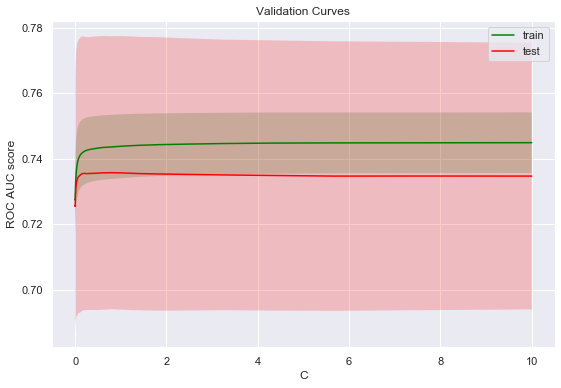

In [18]:
log_reg = LogisticRegression(n_jobs=-1, solver='lbfgs')
param_grid_log = {'C': np.logspace(-5.0, 1.0,)}

grid_search = GridSearchCV(log_reg, param_grid=param_grid_log, scoring='roc_auc',
                           n_jobs=-1, cv=5, return_train_score=True)


grid_search.fit(X_in, y_in)

plot_validation_curves(param_grid_log['C'], grid_search.cv_results_)

#### Hypo-parameter *C* is not sensitive to change

## 5. Model Evaluation

In [19]:
log_reg = LogisticRegression(C=1.0, n_jobs=-1, solver='lbfgs')
log_reg.fit(X_train, y_train)
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = log_reg.predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, y_score)
roc_auc = auc(fpr, tpr)

### ROC-curve

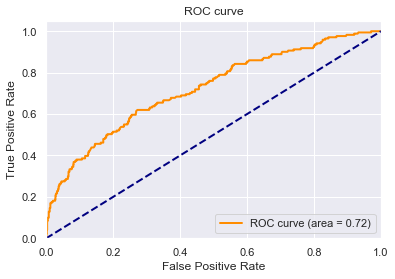

In [20]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### PR-curve

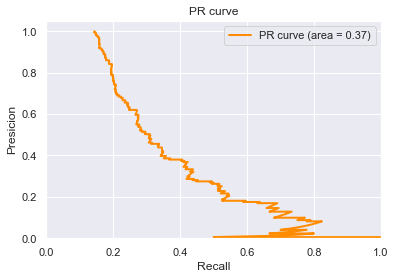

In [21]:
pr, rec, _ = precision_recall_curve(y_valid, y_score)

plt.plot(pr, rec, color='darkorange',
         lw=2, label='PR curve (area = %0.2f)' % auc(rec, pr))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Presicion')
plt.title('PR curve')
plt.legend(loc="upper right")
plt.show()

### Gini

In [22]:
print('GINI valid = {}'.format(2*roc_auc - 1))

GINI valid = 0.44272904483430797
